# Udacity Self-Driving Car NanoDegree, Project 5: Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Python imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
#from sklearn.cross_validation import train_test_split
%matplotlib inline


## Parameters

In [2]:
# put y-coordinate start at 400 to avoid the sky and other non-road features
ystart = 400
# y-coordinate at 656 to avoid the top of the hood
ystop = 656

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 #'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [ystart, ystop] # Min and max in y to search in slide_window()
nload = 8500  #number of examples to load of each category

debug=1

## Read in examples for vehicle and non-vehicles

In [3]:
def load_images(verbose=0):
    vehicles = []
    non_vehicles = []
    for img in glob.glob("vehicles/*/*.png"):
        #image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        image = mpimg.imread(img)
        #read_img = cv2.imread(img)
        #read_img = mpimg.imread(img)
        vehicles.append(image)

    for img in glob.glob("non-vehicles/*/*.png"):
        #image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        image = mpimg.imread(img)
        #read_img = cv2.imread(img)
        #read_img = mpimg.imread(img)
        non_vehicles.append(image)
    
    if(verbose):
        print("{} vehicle examples read, {} actually loaded".format(len(vehicles), nload))
        print("{} non-vehicle examples read, {} actually loaded".format(len(non_vehicles), nload))
        
    ##load a even subset of the examples to balance the training set:
    vehicles = vehicles[:nload]
    non_vehicles = non_vehicles[:nload]
    return vehicles, non_vehicles
# Examples read in as a list of RGB values.
vehicles, non_vehicles = load_images(verbose=1)

example_shape = vehicles[0].shape
print("Shape of an example is: {}".format(example_shape))



8792 vehicle examples read, 8500 actually loaded
8968 non-vehicle examples read, 8500 actually loaded
Shape of an example is: (64, 64, 3)


## Show examples of cars and non-cars

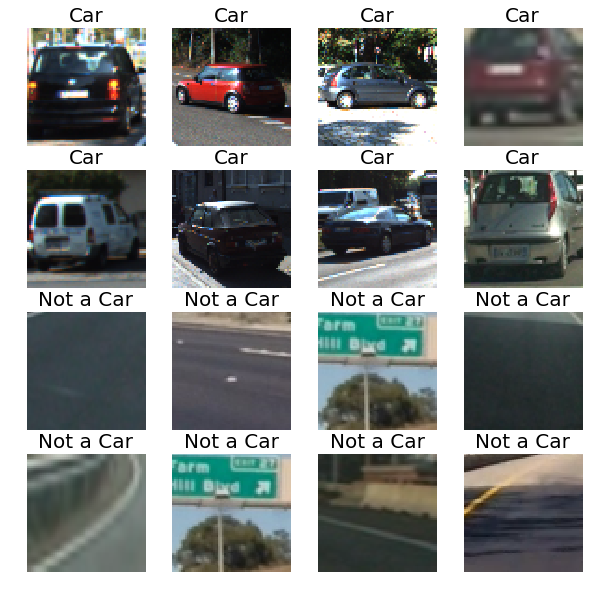

In [4]:

columns = 4
rows = 4
f, ax = plt.subplots(rows, columns, figsize=(10,10))

for i in range(columns):
    for j in range(rows):
        if(i < columns/2):
            randint_car = np.random.randint(0, len(vehicles))
            img = vehicles[randint_car]
            ax[i,j].imshow(img)
            ax[i,j].set_title('Car', fontsize=20)
            ax[i,j].axis('off')
        else:
            randint_non_car = np.random.randint(0, len(non_vehicles))
            img = non_vehicles[randint_non_car]
            ax[i,j].imshow(img)
            ax[i,j].set_title('Not a Car', fontsize=20)
            ax[i,j].axis('off')


## Extract HOG and color histogram features from examples

In [5]:
# Based on code from the lesson: Search and Classify
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Function to handle color conversion
def convert_color(image, color_space = 'RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    return feature_image 

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = cv2.cvtColor(cv2.imread(non_vehicles[randint_non_car]), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

t=time.time()
vehicle_features = extract_features(vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
                                    
non_vehicle_features = extract_features(non_vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print(round(t2-t, 2), 's runtime')

9.02 s runtime


## Show example HOG visualization

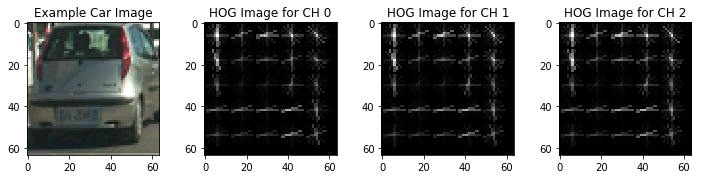

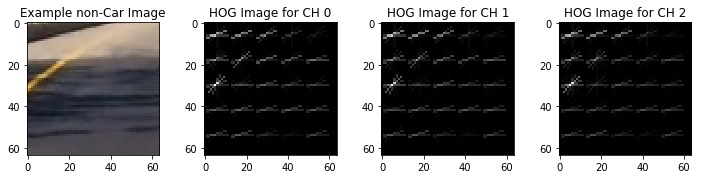

In [6]:
hog_features = []
hog_images = []

feature_image = vehicles[randint_car]

for channel in range(example_shape[2]):
    features, vis = get_hog_features(feature_image[:,:,channel], 
                      orient, pix_per_cell, cell_per_block, 
                      vis=True, feature_vec=True)
    hog_images.append(vis)
    hog_features.append(features)

feature_image2 = non_vehicles[randint_non_car]

    
for channel in range(example_shape[2]):
    features, vis = get_hog_features(feature_image2[:,:,channel], 
                      orient, pix_per_cell, cell_per_block, 
                      vis=True, feature_vec=True)
    hog_images.append(vis)
    hog_features.append(features)    
    
f, ax = plt.subplots(1, 4, figsize=(10,10))
f.tight_layout()
ax[0].imshow(feature_image, cmap='gray')
ax[0].set_title('Example Car Image')

ax[1].imshow(hog_images[0], cmap='gray')
ax[1].set_title('HOG Image for CH 0')

ax[2].imshow(hog_images[1], cmap='gray')
ax[2].set_title('HOG Image for CH 1')

ax[3].imshow(hog_images[2], cmap='gray')
ax[3].set_title('HOG Image for CH 2')

f, ax = plt.subplots(1, 4, figsize=(10,10))
f.tight_layout()

ax[0].imshow(feature_image2, cmap='gray')
ax[0].set_title('Example non-Car Image')

ax[1].imshow(hog_images[3], cmap='gray')
ax[1].set_title('HOG Image for CH 0')

ax[2].imshow(hog_images[4], cmap='gray')
ax[2].set_title('HOG Image for CH 1')

ax[3].imshow(hog_images[5], cmap='gray')
ax[3].set_title('HOG Image for CH 2')

## Train the classifier

In [7]:
## From Color Classify Lecture

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
t = time.time()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t2=time.time()
print(round(t2-t, 2), 's runtime')

Test Accuracy of SVC =  0.9388
6.13 s runtime


## HOG sliding windows

In [8]:
# Based on code from the lecture: Hog Sub-sampling Window Search
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, color_space, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, debug=1, show_search_space=0):
    window_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.
    img_tosearch = img[ystart:ystop,:,:]
    if(debug): print(img_tosearch.shape)

    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    if(debug): print(ctrans_tosearch.shape)
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    if(debug): print("nxblocks = {}, nyblocks = {}".format(nxblocks, nyblocks))
    nfeat_per_block = orient*cell_per_block**2
    if(debug): print("nfeat_per_block = {}".format(nfeat_per_block))
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    if(debug): print("nblocks_per_window = {}".format(nblocks_per_window))
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    if(debug): print("nxsteps = {}, nysteps = {}".format(nxsteps, nysteps))

    # Compute individual channel HOG features for the entire image
    if(hog_channel == 0 or hog_channel == 'ALL'):
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if(hog_channel == 1 or hog_channel == 'ALL'):
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if(hog_channel == 2 or hog_channel == 'ALL'):
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if(hog_channel == 0 or hog_channel == 'ALL'):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if(hog_channel == 1 or hog_channel == 'ALL'):
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if(hog_channel == 2 or hog_channel == 'ALL'):
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            if(hog_channel == 0):
                hog_features = hog_feat1 
            elif(hog_channel == 1): 
                hog_features = hog_feat2 
            elif(hog_channel == 2): 
                hog_features = hog_feat3 
            else: 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            if(hog_feat):
                features = hog_features
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            if(spatial_feat):
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features = np.hstack((features, spatial_features))
            if(hist_feat):
                hist_features = color_hist(subimg, nbins=hist_bins)
                features = np.hstack((features, hist_features))
                
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_features = X_scaler.transform(np.hstack((features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)


            # Calculate window position
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            startx = xbox_left
            endx = xbox_left+win_draw
            starty = ytop_draw+ystart
            endy = ytop_draw+win_draw+ystart
            if(show_search_space) : window_list.append(((startx, starty), (endx, endy)))
            
            if test_prediction == 1:
                #cv2.rectangle(draw_img,(startx, starty),(endx, endy),(0,0,255),6) 
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))

                                
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def hog_sliding_windows(image, scale, ystart, ystop, showImage=1):
    window_list = find_cars(image, ystart=ystart, ystop=ystop, scale=scale, 
                            svc=svc, color_space=color_space, X_scaler=X_scaler, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            spatial_size=spatial_size, hist_bins=hist_bins, debug=0)
    image = np.uint8(image*255.)
    out_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)                    
    if(showImage):
        f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
        ax1.imshow(out_img)
    return window_list, out_img
        



## Implement heatmaps to weed out duplicate detections and false positives

In [9]:
# Based on code from the Multiple Detections & False Positives lecture notes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def heatmaps(image, heat, box_list, heat_threshold=1, verbose=0, limit_frames=-1, return_raw_heat=0):
    if(verbose):
        print("Number of frames: {}".format(len(box_list)))
    #restrict to (limit_frames) frames
    if(limit_frames !=-1):
        if(len(box_list) > limit_frames): 
            box_list.pop(0)
    
    # Add heat to each box in box list
    for boxes_in_frame in box_list: 
        #print(boxes_in_frame)
        heat = add_heat(heat,boxes_in_frame)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)
    # Visualize the heatmap when displaying  
    heatmap = np.clip(heat, 0, 255)


    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    image = np.uint8(image*255.)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    text = 'Cars found: {}'.format(labels[1]) 
    heatmap = cv2.putText(heatmap, text, org=(0,50), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,255,255))
    
    if(verbose):
        print(labels[1], 'cars found')

    if(return_raw_heat):
        return draw_img, heat, labels
    else:
        return draw_img, heatmap


## Run the hog sliding window function with different scales and show the result for all the test images

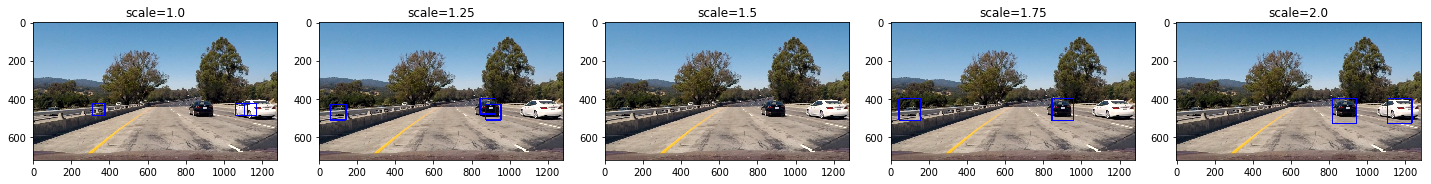

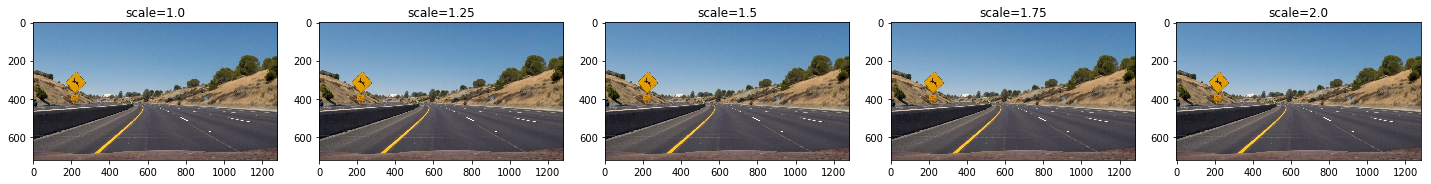

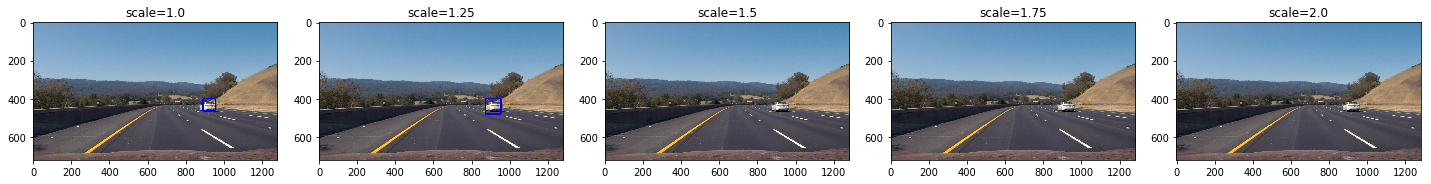

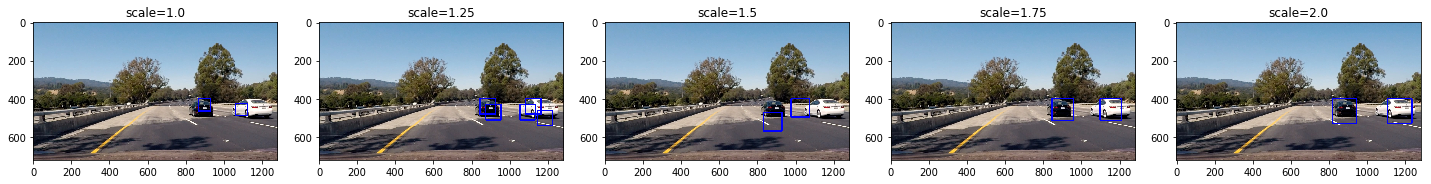

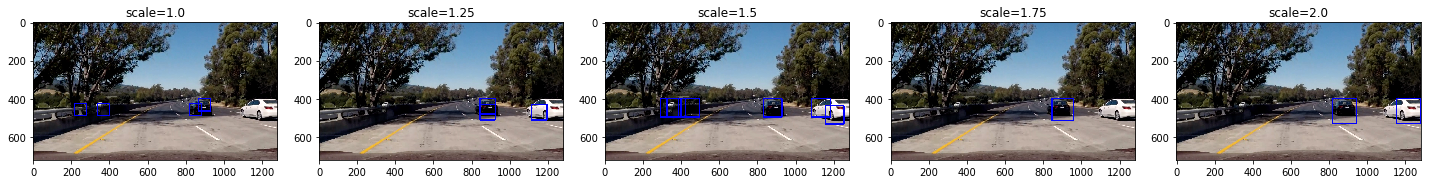

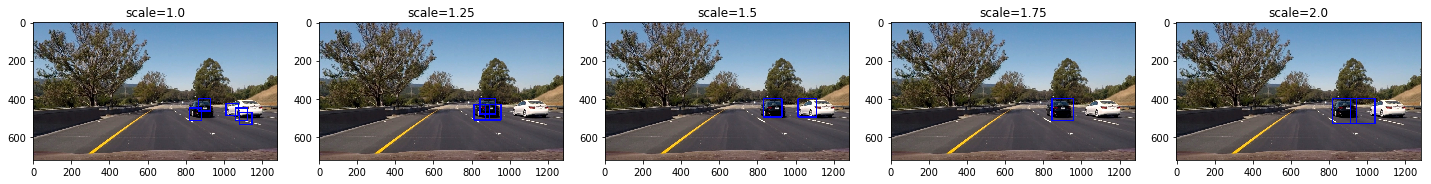

In [10]:
heatmap_list = []

for img in glob.glob("test_images/test*.jpg"):
    image = mpimg.imread(img)
    file_image = image.astype(np.float32)/255.
    #file_image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    window_test = []
    image = []
    
    test_scale = [1.0, 1.25, 1.5, 1.75, 2.0]

    for scale in test_scale:
        window_test_tmp, image_tmp = hog_sliding_windows(file_image, scale, ystart=ystart, ystop=ystop, showImage=0)
        window_test.append(window_test_tmp)
        image.append(image_tmp)


    
    f, ax = plt.subplots(1, len(image), figsize=(20,10))
    f.tight_layout()
    for i in range(len(image)):
            ax[i].set_title('scale={}'.format(test_scale[i]))
            ax[i].imshow(image[i])




## Show search space of the different scales

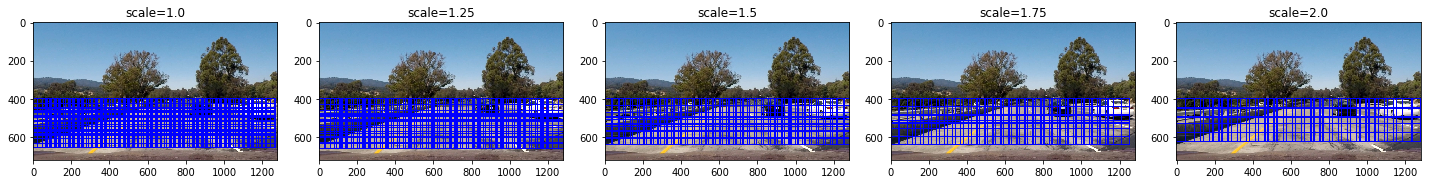

In [11]:
heatmap_list = []
heatmap_bbox_images = []

image = mpimg.imread('test_images/test1.jpg')
file_image = image#.astype(np.float32)/255.
image = []    

test_scale = [1.0, 1.25, 1.5, 1.75, 2.0]

for scale in test_scale:
    window_list = find_cars(file_image, ystart=ystart, ystop=ystop, scale=scale, 
                            svc=svc, color_space=color_space, X_scaler=X_scaler, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            spatial_size=spatial_size, hist_bins=hist_bins, debug=0,show_search_space=1 )
    out_img = draw_boxes(file_image, window_list, color=(0, 0, 255), thick=6)                    

    image.append(out_img)

    
f, ax = plt.subplots(1, len(image), figsize=(20,10))
f.tight_layout()
for i in range(len(image)):
    ax[i].set_title('scale={}'.format(test_scale[i]))
    ax[i].imshow(image[i])

## Show heatmap for a test image

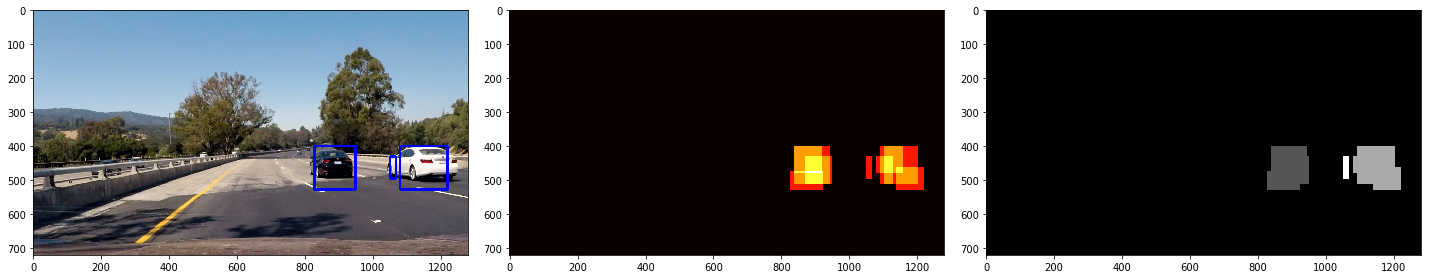

In [12]:
for img in glob.glob("test_images/test4.jpg"):
    test_scale = [1.25, 1.50, 1.75, 2.0]
    windows = []
    image = mpimg.imread(img)
    image = image.astype(np.float32)/255.
    for scale in test_scale:
        windows += find_cars(image, ystart=ystart, ystop=ystop, scale=scale, svc=svc, color_space=color_space, X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, debug=0)
         

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    result, heatmap, labels = heatmaps(image, heat, [windows], heat_threshold=1, verbose=0, limit_frames=100, return_raw_heat=1)


    f, ax = plt.subplots(1, 3, figsize=(20,10))
    f.tight_layout()
    ax[0].imshow(result)
    ax[1].imshow(heatmap, cmap='hot')
    ax[2].imshow(labels[0], cmap='gray')

## Processing function

In [13]:

def process_image(image):
    global window_list    
    test_scale = [1.5, 2.0]
    windows = []
    image = image.astype(np.float32)/255.
    for scale in test_scale:
        windows += find_cars(image, ystart=ystart, ystop=ystop, scale=scale, svc=svc, color_space=color_space, X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, debug=0)
    
    #image = np.uint8(image*255.)
    #result = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
        
    if(len(windows) != 0):
        window_list.append(windows)
        #window_list = np.concatenate([window_list, hot_windows])
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    result, heatmap = heatmaps(image, heat, window_list, heat_threshold=10, verbose=0, limit_frames=25)
    #result = np.uint8(result*255)
    debug=1
    ## debug - add heatmap to final video
    if(debug):
        f = plt.Figure(frameon=False, figsize=(17.78,10))
        ax1 = f.add_axes([0, 0, 1, 1])
        ax1.imshow(heatmap, cmap='hot')
        plt.close(f)
        plt.axis('off')
        ax1.axis('off')
        f.patch.set_visible(False)
        canvas = FigureCanvas(f) 
        canvas.draw()
        out_img = np.fromstring(f.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        out_img = out_img.reshape(f.canvas.get_width_height()[::-1] + (3,))
        result = np.concatenate((result, out_img), axis=1)
        
    return result


## Code for processing the video

In [14]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas 


[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [10:43<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 17min 22s, sys: 9.58 s, total: 17min 32s
Wall time: 10min 44s


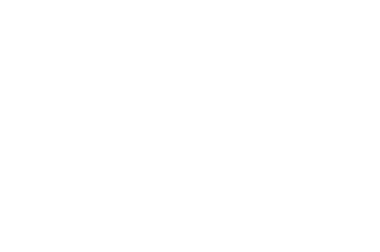

In [15]:
global window_list
window_list = []
window_list.append([((0, 0), (0, 0))]) # dummy window to add for the first box

output = 'output.mp4'
#input1 = VideoFileClip("project_video.mp4").subclip(5,45)
#input1 = VideoFileClip("project_video.mp4").subclip(26,30)
#input1 = VideoFileClip("test_video.mp4")
input1 = VideoFileClip("project_video.mp4")




clip = input1.fl_image(process_image) 
%time clip.write_videofile(output, audio=False)

